# **MINST - DIGITAL RECONIZER**

### My First competition.

In [1]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow.keras as keras

### 1st Part: EDA

In [2]:
PATH_TRAIN = r"/kaggle/input/digit-recognizer/train.csv"
PATH_TEST  = r"/kaggle/input/digit-recognizer/test.csv"

# Train Dataset
train = genfromtxt(PATH_TRAIN, delimiter=',')[1:]
train_images = np.array(train[:,1:]).reshape(-1,28,28,1)/255.0
train_labels = np.array(train[:,0])

# Test Dataset
test = genfromtxt(PATH_TEST, delimiter=',')[1:]
test_images = np.array(test).reshape(-1,28,28,1)/255.0

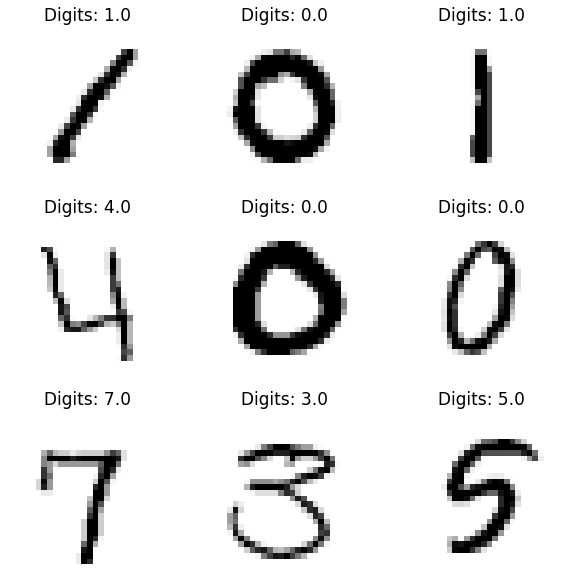

In [3]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title(f"Digits: {train_labels[i]}", fontsize=17)
    plt.axis("off")
plt.show()

In [4]:
# Split TRAIN DATA

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.3, random_state=123)

## **Ready Data for TensorFlow Consumption**

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

BATCH_SIZE = 128
SHUFFLE_SIZE = 3000

train_f = train_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
train_fm = train_f.cache().prefetch(1)

test_f = val_ds.batch(BATCH_SIZE)
test_fm = test_f.cache().prefetch(1)

2022-02-10 12:56:54.693442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 12:56:54.786002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 12:56:54.786735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 12:56:54.789217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## **Build the Model**

In [6]:
img_shape = train_images.shape[1:]
img_shape

(28, 28, 1)

In [7]:
# Number Classes
num_classes = len(np.unique(train_labels))
num_classes

10

In [8]:
# Clean Previous Models
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# Create Model
model = tf.keras.Sequential([
    Conv2D(32, 3, activation='relu',input_shape=img_shape),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Dropout(0.2),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu',padding='same'),
    Dense(256, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile Model

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
loss=SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

# Train Model
epochs = 20
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 35))

history = model.fit(train_fm, epochs=epochs,
verbose=1, validation_data=test_fm, callbacks=[lr_schedule])

Epoch 1/20


2022-02-10 12:56:58.548116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-10 12:56:59.482484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


230/230 [==============================] - 9s 9ms/step - loss: 0.3905 - accuracy: 0.8708 - val_loss: 0.0739 - val_accuracy: 0.9771
Epoch 2/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0873 - accuracy: 0.9743 - val_loss: 0.0678 - val_accuracy: 0.9806
Epoch 3/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0631 - accuracy: 0.9809 - val_loss: 0.0587 - val_accuracy: 0.9809
Epoch 4/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0492 - accuracy: 0.9853 - val_loss: 0.0553 - val_accuracy: 0.9820
Epoch 5/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0389 - accuracy: 0.9886 - val_loss: 0.0496 - val_accuracy: 0.9841
Epoch 6/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0376 - val_accuracy: 0.9894
Epoch 7/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0298 - accuracy: 0.9916 - val_loss: 0.0378 - val_accuracy: 0.9892
Epoch 8/20
230/23

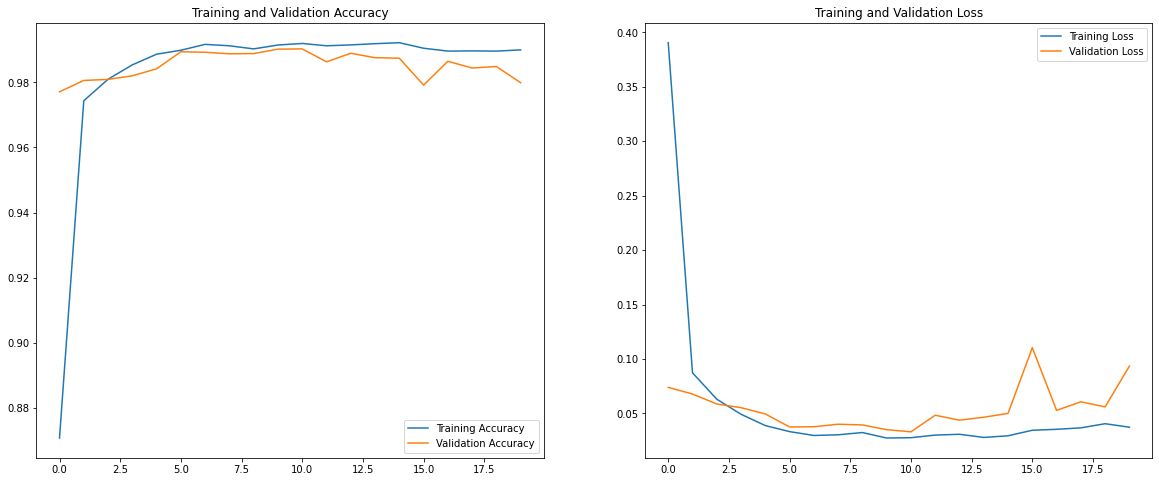

In [9]:
# Plot Accuracy
length_history = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(length_history)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

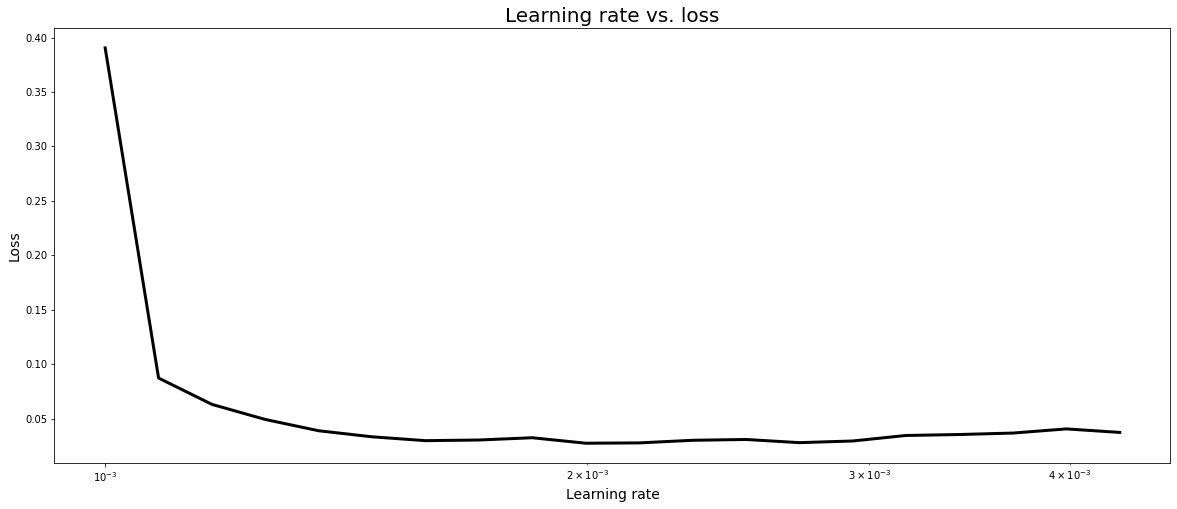

In [10]:
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.figure(figsize=(20, 8))
plt.semilogx(
    learning_rates, 
    history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.show()

In [11]:
# The Best Learning Rate
inital_ds = pd.DataFrame(history.history)
index_min_loss = inital_ds['loss'].idxmin() 
best_lr_loss = inital_ds['lr'][index_min_loss]
print(f"The best learning rate (Loss): {best_lr_loss:.2}")

The best learning rate (Loss): 0.0018


In [12]:
# Clean Previous Models
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# Compile Model
learning_rate = best_lr_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.7)

model.compile(optimizer=optimizer,
loss=SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

# Train Model
epochs = 70
model_checkpoint = keras.callbacks.ModelCheckpoint('my_checkpoint.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=15)
history = model.fit(train_fm, epochs=epochs,
                    verbose=1,
                    validation_data=test_fm,
                   callbacks=[model_checkpoint, early_stopping])

Epoch 1/70
230/230 [==============================] - 2s 8ms/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0498 - val_accuracy: 0.9913
Epoch 2/70
230/230 [==============================] - 2s 7ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0558 - val_accuracy: 0.9899
Epoch 3/70
230/230 [==============================] - 2s 8ms/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 0.0511 - val_accuracy: 0.9904
Epoch 4/70
230/230 [==============================] - 2s 7ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.0472 - val_accuracy: 0.9913
Epoch 5/70
230/230 [==============================] - 2s 9ms/step - loss: 0.0168 - accuracy: 0.9960 - val_loss: 0.0677 - val_accuracy: 0.9894
Epoch 6/70
230/230 [==============================] - 2s 7ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.0450 - val_accuracy: 0.9899
Epoch 7/70
230/230 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0475 - val_accuracy: 0.9912
Epoch 

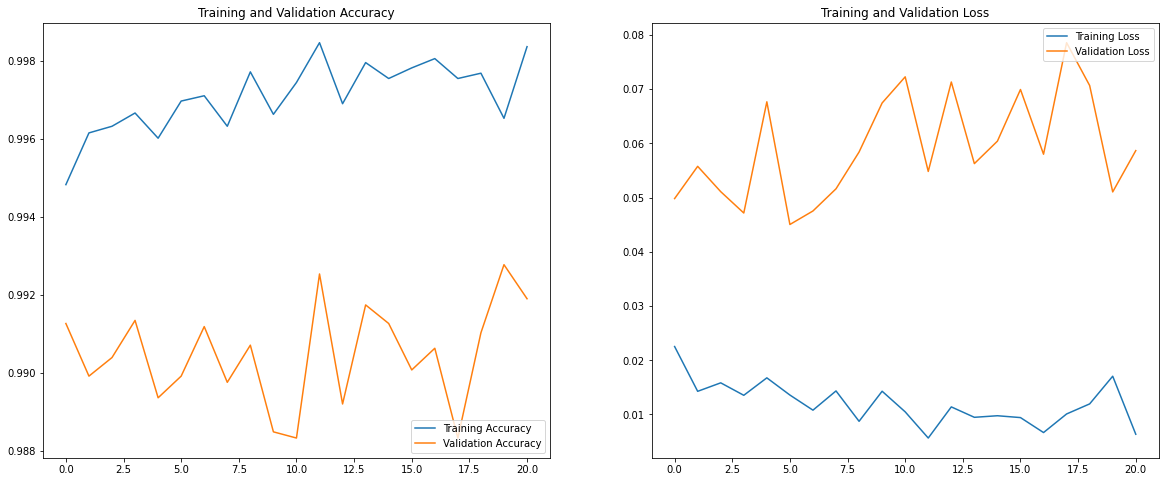

In [13]:
# Plot Accuracy
length_history = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(length_history)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Evaluate Model**

In [14]:
model = keras.models.load_model("my_checkpoint.h5")

In [15]:
results = model.predict(test_images).argmax(axis=1)
ImageID = np.arange(len(results))+1
Out = pd.DataFrame([ImageID,results]).T
Out.rename(columns = {0:'ImageId', 1:'Label'})
Out.to_csv('submission.csv', header =  ['ImageId', 'Label' ], index = None)